#### Training with UNSW for all classes

Get the dataset from `https://research.unsw.edu.au/projects/unsw-nb15-dataset`.

In [1]:
import os
import pandas as pd
import numpy as np
import csv
import os
import time
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

# Read in the training CSV file
print("Reading Training csv file.")
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)
obj_df = df1
obj_df["proto"] = obj_df["proto"].astype('category')
obj_df["service"] = obj_df["service"].astype('category')
obj_df["state"] = obj_df["state"].astype('category')
obj_df["proto_cat"] = obj_df["proto"].cat.codes
obj_df["service_cat"] = obj_df["service"].cat.codes
obj_df["state_cat"] = obj_df["state"].cat.codes

obj_df["proto"] = obj_df["proto_cat"]
obj_df["service"] = obj_df["service_cat"]
obj_df["state"] = obj_df["state_cat"]

obj_df.drop('proto_cat', axis=1, inplace=True)
obj_df.drop('service_cat', axis=1, inplace=True)
obj_df.drop('state_cat', axis=1, inplace=True)

y = df1["attack_cat"].values
X = obj_df.values[:,:-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Reading Training csv file.


In [2]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(140272, 43) (140272,) (35069, 43) (35069,)


In [3]:
from sklearn import tree
from sklearn.model_selection import cross_val_predict

#dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
#dt_clf = tree.DecisionTreeClassifier(max_depth=4, max_leaf_nodes=20)
dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)

#y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=2)
print(dt_clf.fit(X_train, y_train))

print('Number of nodes in the decision tree {}.'.format(dt_clf.tree_.node_count))
print('Number of threshold in the decision tree {}.'.format(len(dt_clf.tree_.threshold)))
print('Number of leaves in the decision tree {}.'.format(dt_clf.tree_.n_leaves))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, dt_clf.predict(X_test)), accuracy_score(y_train, dt_clf.predict(X_train)))

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
Number of nodes in the decision tree 599.
Number of threshold in the decision tree 599.
Number of leaves in the decision tree 300.
0.8602469417434201 0.8659532907494012


In [4]:
threshold = dt_clf.tree_.threshold
import pandas as pd
df_train = pd.DataFrame(data = X_train, columns = range(X_train[0].shape[0]))
df_test = pd.DataFrame(data = X_test, columns = range(X_test[0].shape[0]))
df_train.shape, df_test.shape
df = pd.concat([df_train, df_test])
unique_vals = []
for i in df.columns:
    unique_vals.append(df[i].unique())
flatten_list = np.concatenate(unique_vals).ravel()
print('Max and Min values of thresholds in decision tree are', max([int(i) for i in list(set(threshold))]), min([int(i) for i in list(set(threshold))]))

Max and Min values of thresholds in decision tree are 42611110 -2


#### Displaying the nodes/leaves that were visited for training each class. Also display which are the intermeduate nodes and which are the leaves.

In [5]:
# Get the paths to the leaf nodes for each class
clf = dt_clf
leaf_paths = {}
for class_label in np.unique(y_train):
    leaf_paths[class_label] = clf.decision_path(X_train[y_train == class_label])

# Group the leaf nodes for each class
class_groups = {}
for class_label, paths in leaf_paths.items():
    group = {'leaves': set(), 'intermediate': set()}
    for path in paths:
        # Get the indices of the nodes in the path
        node_indices = np.where(path.toarray().flatten())[0]
        # Identify leaf nodes and intermediate nodes
        for idx in node_indices:
            node = clf.tree_.value[idx].argmax()
            if clf.tree_.children_left[idx] == -1 and clf.tree_.children_right[idx] == -1:
                # Verify leaf node belongs to the current class
                if node == class_label:
                    group['leaves'].add(idx)
            else:
                group['intermediate'].add(idx)
    class_groups[class_label] = group

# Verify leaf nodes don't belong to other classes
for class_label, groups in class_groups.items():
    for other_class_label, other_groups in class_groups.items():
        if other_class_label != class_label:
            intersection = groups['leaves'].intersection(other_groups['leaves'])
            if intersection:
                print(f"Warning: Leaf nodes for class {class_label} intersect with class {other_class_label}: {intersection}")

leaf_nodes_per_class = {}
intermediate_nodes_per_class = {}
# Print the groups
for class_label, groups in class_groups.items():
    print(f"Class {class_label}:")
    print("Intermediate Nodes:", groups['intermediate'])
    intermediate_nodes_per_class[class_label] = groups['intermediate']
    print("Leaf Nodes:", groups['leaves'])
    leaf_nodes_per_class[class_label] = groups['leaves']

Class Analysis:
Intermediate Nodes: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 524, 525, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 35, 36, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 57, 58, 59, 61, 62, 63, 71, 72, 73, 74, 75, 76, 81, 82, 85, 89, 97, 98, 106, 111, 121, 148, 149, 156, 157, 170, 187, 207, 208, 215, 216, 218, 223, 233, 301, 305, 313, 341, 346, 355, 407, 408, 435, 436, 438, 446, 454, 500}
Leaf Nodes: set()
Class Backdoor:
Intermediate Nodes: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 524, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 52, 55, 56, 57, 58, 59, 61, 62, 63, 65, 577, 67, 68, 70, 75, 76, 77, 78, 80, 81, 82, 83, 85, 89, 90, 97, 98, 99, 100, 101, 103, 105, 106, 107, 109, 110, 111, 112, 121, 122, 124, 125, 127, 128, 129, 131, 133, 134, 136, 137, 139, 142, 146, 148, 149, 150, 153, 156, 157, 159, 160, 161, 162, 163, 166, 167, 170, 176, 181, 185, 187, 201, 207, 208, 211, 212, 

##### Sanity checks that there is no sharing of leaves between classes.

In [6]:
for i in intermediate_nodes_per_class.keys():
    for j in leaf_nodes_per_class.keys():
        if i!=j:
            intersection = leaf_nodes_per_class[i].intersection(leaf_nodes_per_class[j])
            if intersection:
                print(f'Warning: The leaf nodes between class {i} and {j} has common leaves: {intersection}.')
    

#### Creating a set containing intermediate nodes and leafs.

In [7]:
intermediate_nodes = set()
leaf_nodes = set()
for i in intermediate_nodes_per_class.keys():
    intermediate_nodes.update(intermediate_nodes_per_class[i])
    
for j in leaf_nodes_per_class.keys():
    leaf_nodes.update(leaf_nodes_per_class[j])

##### Check the nodes that were used in forget class but not in other classes.

In [8]:
forget_class = 'Analysis'
segregated_nodes = intermediate_nodes_per_class[forget_class] - intermediate_nodes
print(segregated_nodes)

set()


#### Nodes removal

Accuracy before unlearning: 0.821893980438564


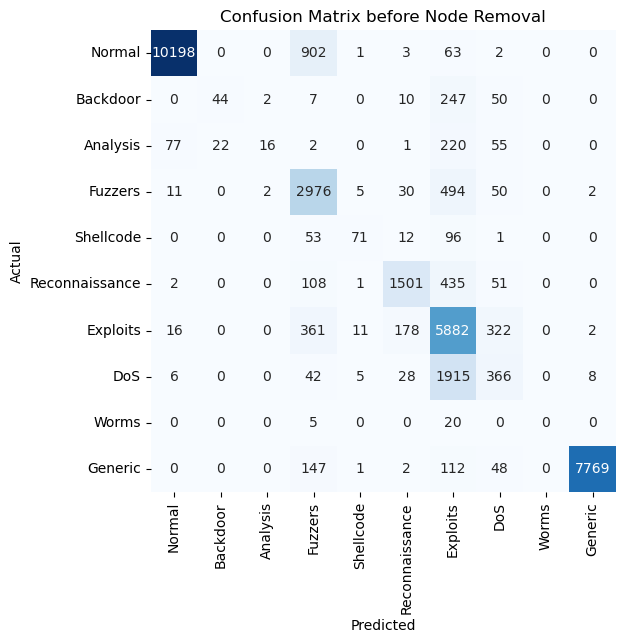

Accuracy after unlearning for class Analysis : 0.821893980438564


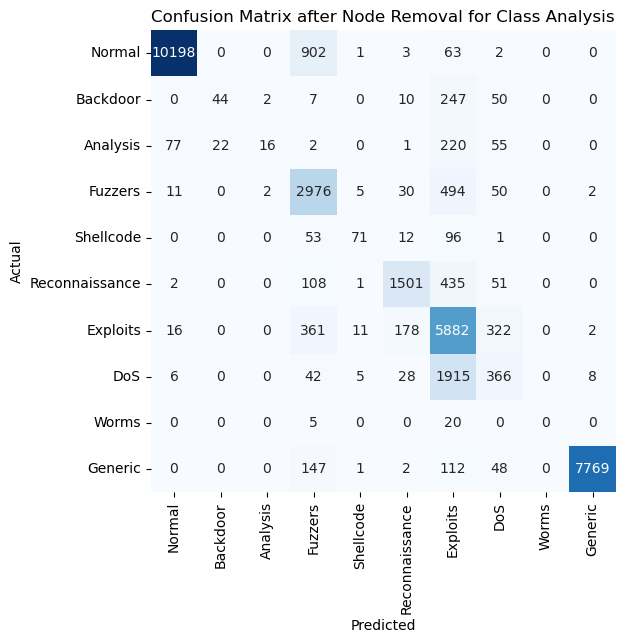

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def remove_nodes_for_class(tree, class_label_to_unlearn, X_train, y_train):
    """
    Prune nodes associated with a specific class label from a decision tree.

    Parameters:
    - tree: DecisionTreeClassifier object representing the decision tree model.
    - class_label_to_unlearn: Label of the class for which nodes need to be pruned.
    - X_train: Training features.
    - y_train: Training labels.

    Returns:
    - pruned_tree: New DecisionTreeClassifier object with nodes associated with the specified class pruned.
    """

    # Initialize a new decision tree classifier
    pruned_tree = DecisionTreeClassifier(random_state=42)

    # Copy the structure of the original tree
    pruned_tree = tree.__class__()
    pruned_tree.__dict__ = tree.__dict__.copy()

    # Find instances of the specified class label in the training data
    class_indices = np.where(y_train == class_label_to_unlearn)[0]

    # Find the indices of nodes associated with the specified class label
    nodes_to_prune = []
    for idx in class_indices:
        node_index = tree.apply(X_train[idx:idx+1])[0]
        if tree.tree_.value[node_index].argmax() == class_label_to_unlearn:
            nodes_to_prune.append(node_index)

    # Prune the identified nodes
    for node_index in nodes_to_prune:
        pruned_tree.tree_.children_left[node_index] = -1
        pruned_tree.tree_.children_right[node_index] = -1

    return pruned_tree

# Train a decision tree classifier on the training data
tree_classifier = DecisionTreeClassifier(random_state=42, max_depth=8)
tree_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = tree_classifier.predict(X_test)

# Calculate accuracy before unlearning
accuracy_before_unlearning = accuracy_score(y_test, y_pred)
print("Accuracy before unlearning:", accuracy_before_unlearning)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels= df1["attack_cat"].unique().tolist())
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=df1["attack_cat"].unique().tolist(), yticklabels=df1["attack_cat"].unique().tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix before Node Removal')
plt.show()


# Specify the class label for unlearning (e.g., class 9 for digit 9 in MNIST)
class_label_to_remove = 'Analysis'

# Remove nodes associated with the specified class label
pruned_tree = remove_nodes_for_class(tree_classifier, class_label_to_remove, X_train, y_train)

# Make predictions on the testing set using the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)

# Calculate accuracy after unlearning
accuracy_after_unlearning = accuracy_score(y_test, y_pred_pruned)
print("Accuracy after unlearning for class", class_label_to_remove, ":", accuracy_after_unlearning)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_pruned, labels=df1["attack_cat"].unique().tolist())
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=df1["attack_cat"].unique().tolist(), yticklabels=df1["attack_cat"].unique().tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after Node Removal for Class {}'.format(class_label_to_remove))
plt.show()


This is not forgetting as the accuracy drop is minimal and it is across all the classes, not only in `forget class` (in this case it is Analysis).

# Extracting the decision rules with different mechanism: `chain` of `if` statements

#### Runt this cell twice.

In [11]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= f'{class_names[l]}' #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(43)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = dt_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(dt_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open('mnist_decision_tree_inference.py', 'w') as f:
    f.write(cap.stdout)

In [12]:
from mnist_decision_tree_inference import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
    
y_train_pred_tree = []
for i,test_samples in enumerate(X_train):
    y_train_pred_tree.append(decision_tree_inference(test_samples))
    
for i in range(len(y_train_pred_tree)):
    if y_train_pred_tree[i] is None:
        y_train_pred_tree[i] = 0

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_test_pred_tree), accuracy_score(y_train, y_train_pred_tree))

0.8602469417434201 0.8659461617428995


#### Verifying that the number of 'if' statements is equal to the number of leaves.

In [13]:
with open('mnist_decision_tree_inference.py', 'r') as f:
    rules = f.readlines()

counter_if = 0
for rule in rules:
    if 'if' in rule:
        counter_if = counter_if+1
print(counter_if)

300


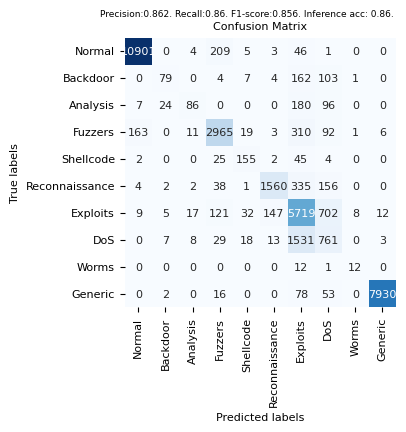

Precision: 0.8618030195995061
Recall: 0.8602469417434201
F1 Score: 0.856137146650361
True Positives for Each Class: [10901    79    86  2965   155  1560  5719   761    12  7930]
                precision    recall  f1-score   support

      Analysis       0.67      0.22      0.33       393
      Backdoor       0.66      0.22      0.33       360
           DoS       0.39      0.32      0.35      2370
      Exploits       0.68      0.84      0.75      6772
       Fuzzers       0.87      0.83      0.85      3570
       Generic       1.00      0.98      0.99      8079
        Normal       0.98      0.98      0.98     11169
Reconnaissance       0.90      0.74      0.81      2098
     Shellcode       0.65      0.67      0.66       233
         Worms       0.55      0.48      0.51        25

      accuracy                           0.86     35069
     macro avg       0.74      0.63      0.66     35069
  weighted avg       0.86      0.86      0.86     35069



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tree, labels=df1["attack_cat"].unique().tolist())

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df1["attack_cat"].unique().tolist(), yticklabels=df1["attack_cat"].unique().tolist(), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig('confusion_matrix_mnist.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

##### Forgetting class `Generic`.   

Unlearning time: 0.005032777786254883 seconds
0.8602469417434201
Inference time per sample after unlearn: 4.416095537082712e-05 seconds


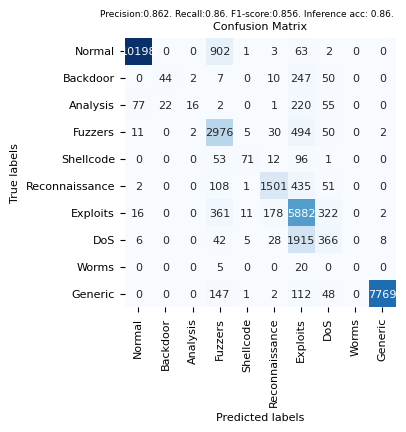

Precision: 0.8618030195995061
Recall: 0.8602469417434201
F1 Score: 0.856137146650361
True Positives for Each Class: [10198    44    16  2976    71  1501  5882   366     0  7769]
                precision    recall  f1-score   support

      Analysis       0.67      0.22      0.33       393
      Backdoor       0.66      0.22      0.33       360
           DoS       0.39      0.32      0.35      2370
      Exploits       0.68      0.84      0.75      6772
       Fuzzers       0.87      0.83      0.85      3570
       Generic       1.00      0.98      0.99      8079
        Normal       0.98      0.98      0.98     11169
Reconnaissance       0.90      0.74      0.81      2098
     Shellcode       0.65      0.67      0.66       233
         Worms       0.55      0.48      0.51        25

      accuracy                           0.86     35069
     macro avg       0.74      0.63      0.66     35069
  weighted avg       0.86      0.86      0.86     35069

[0]


In [15]:
import time
start_time = time.time()

forget_class = 'Generic'
with open('mnist_decision_tree_inference.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

node_removal=[]
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        
        

with open('forget_9_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()
from forget_9_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_pred_pruned, labels=df1["attack_cat"].unique().tolist())

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df1["attack_cat"].unique().tolist(), yticklabels=df1["attack_cat"].unique().tolist(), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearning method: from class 0 to 8.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

# Filter training and test data for classes 0 to 8
X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 0.5008280277252197 seconds
Accuracy: 0.7317489788340141
